# CAPSTONE PROJECT - NewsK: Multilingual Personalized News Recommendation

In [5]:
!pip install networkx sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 4.2 MB/s eta 0:00:00


# 1. Imports and Device Configuration

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ndcg_score
from tqdm import tqdm
import warnings
from sklearn.manifold import TSNE
from typing import List, Tuple, Dict
import logging
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.metrics import ndcg_score, confusion_matrix
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
from IPython.display import display, Markdown
warnings.filterwarnings("ignore")
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 2. Loading the datasets

In [7]:
# Define column names for news and behaviors datasets
news_columns = ["itemId", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"]
behaviors_columns = ["impressionId", "userId", "timestamp", "click_history", "impressions"]

# Data Loading Function
def load_dataset(news_path: str, behaviors_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    print(f"Loading dataset from {news_path} and {behaviors_path}")
    news_df = pd.read_csv(news_path, sep='\t', names=news_columns, header=None)
    behaviors_df = pd.read_csv(behaviors_path, sep='\t', names=behaviors_columns, header=None)
    return news_df, behaviors_df


# File paths for train and dev datasets
train_news_path = '/content/train_news.tsv'
train_behaviors_path = '/content/train_behaviors.tsv'
dev_news_path = '/content/dev_news.tsv'
dev_behaviors_path = '/content/dev_behaviors.tsv'

# Load the datasets
train_news, train_behaviors = load_dataset(train_news_path, train_behaviors_path)
dev_news, dev_behaviors = load_dataset(dev_news_path, dev_behaviors_path)

Loading dataset from /content/train_news.tsv and /content/train_behaviors.tsv
Loading dataset from /content/dev_news.tsv and /content/dev_behaviors.tsv


# 3. Exploratory Data Analysis (EDA)

In [8]:
# Display the first few rows of each dataset to understand the structure
train_news.head()

,itemId,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [9]:
train_behaviors.head()

,impressionId,userId,timestamp,click_history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [10]:
dev_news.head()

,itemId,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N18955,health,medical,Dispose of unwanted prescription drugs during ...,NaN,https://assets.msn.com/labs/mind/AAISxPN.html,"[{""Label"": ""Drug Enforcement Administration"", ...",[]
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [11]:
dev_behaviors.head()

,impressionId,userId,timestamp,click_history,impressions
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...


# Dataset Overview

The datasets contain various fields that are relevant to both news and user behaviors, including unique article IDs, categories, headlines, URLs, and interactions. Here’s an overview of the first few rows:

#### News Datasets

It contains information like:
- Unique news IDs, categories, and subcategories.
- Headlines and summaries of articles.
- Article URLs and metadata, including tags (e.g., people, organizations).

#### Behaviors Datasets

It captures:
- User interactions with news articles, with columns for user IDs, session IDs, timestamps, and the list of articles they interacted with (clicked, displayed, etc.).

# Exploratory Data Analysis (EDA)

Before we move forward with building the recommendation model, the first step will be to conduct a comprehensive Exploratory Data Analysis (EDA). Below is an outline of the steps we will cover:

### 1. Data Inspection

- Understand missing values, data types, and statistics.
- Identify unique values and distribution of categorical variables (e.g., news categories, subcategories).

### 2. Behavioral Analysis

- Analyze user interactions: How often do users click on certain articles?
- Analyze time-related behavior (e.g., activity over time).

### 3. Content Analysis

- Investigate the most frequent words or phrases in article headlines and summaries.
- Perform keyword extraction and categorize topics.

# Modeling

### 1. Data Preprocessing
We start by handling missing values and combining the article titles and abstracts into a single content field. This gives us a unified text field for feature extraction, whether using simple TF-IDF or more advanced embeddings.

### 2. Baseline Model: TF-IDF and Cosine Similarity
In the baseline model, we use **TF-IDF** to transform article content into feature vectors. Then, we compute **cosine similarity** between these vectors to recommend similar articles. It's fast, simple, and effective!

### 3. Complex Model: LLM Embeddings
For a deeper understanding of the text, we use **Large Language Models (LLMs)** like `DistilBERT` to generate embeddings. These embeddings capture richer semantic relationships in the content. We then compute cosine similarity on the embeddings for more context-aware recommendations.

### 4. Evaluation
We’ll evaluate our models using **Precision@K** and **Recall@K** to see how accurately the recommendations match what users actually clicked on. This helps ensure we're recommending the right content.

### 5. Models Comparison
Lastly, we compare the performance of the TF-IDF model with the LLM embeddings. We'll weigh simplicity vs. contextual depth and consider which approach is more scalable and accurate for real-world use.

### 1. Data Inspection


 Dataset: News Dataset

Train Dataset Shape: (51282, 8)
Dev Dataset Shape: (42416, 8)

Data Types and Missing Values:
           Column Data Type_x  Train Non-Null Count  Train Null Count  Train Null Percentage Data Type_y  Dev Non-Null Count  Dev Null Count  Dev Null Percentage
           itemId      object                 51282                 0               0.000000      object               42416               0             0.000000
         category      object                 51282                 0               0.000000      object               42416               0             0.000000
      subcategory      object                 51282                 0               0.000000      object               42416               0             0.000000
            title      object                 51282                 0               0.000000      object               42416               0             0.000000
         abstract      object                 48616              2666  

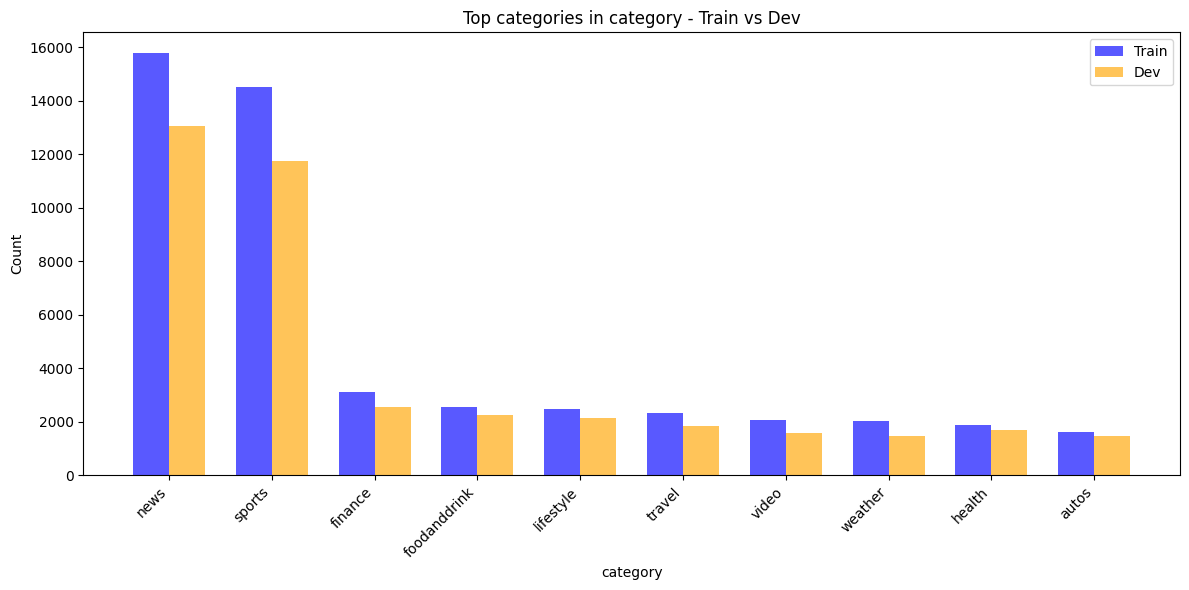


Unique Values and Distribution for subcategory:
Train Dataset:
subcategory
newsus                      6564
football_nfl                5420
newspolitics                2826
newscrime                   2254
weathertopstories           2047
newsworld                   1720
football_ncaa               1665
baseball_mlb                1661
basketball_nba              1555
newsscienceandtechnology    1210
Number of unique values: 264

Dev Dataset:
subcategory
newsus                      5335
football_nfl                4747
newspolitics                2398
newscrime                   1797
newsworld                   1525
baseball_mlb                1502
weathertopstories           1460
football_ncaa               1271
basketball_nba              1221
newsscienceandtechnology     971
Number of unique values: 257


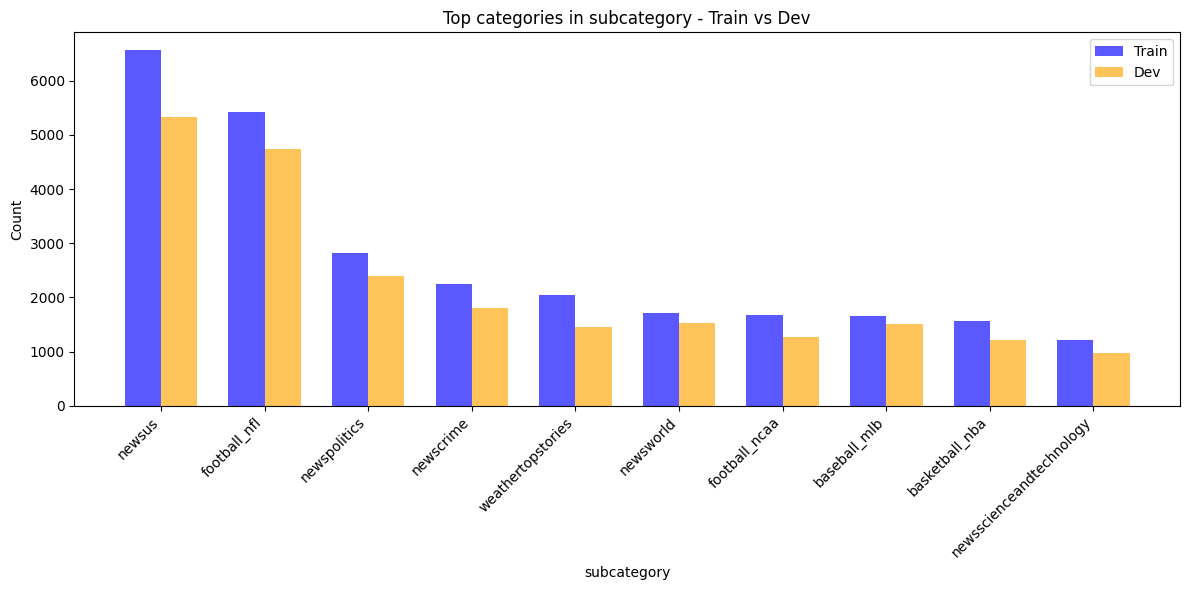


Unique Values and Distribution for title:
Train Dataset:
title
Photos of the Day                                                               15
Look of the Day                                                                 14
Friday's Scores                                                                  8
Video appears to show Astros stealing signs against Danny Farquhar               6
Winter already? Snow, deep freeze from Rockies to East Coast                     5
Morning news briefing from CNN                                                   5
Yu Darvish sends hilarious tweet about Astros cheating scandal                   5
Sunday Real Estate: 3 Luxurious Florida Homes                                    5
Microsoft vows to 'honor' California's sweeping privacy law across entire US     5
This company will pay you $1,000 to watch Hallmark Christmas movies              5
Number of unique values: 50434

Dev Dataset:
title
Look of the Day                                        

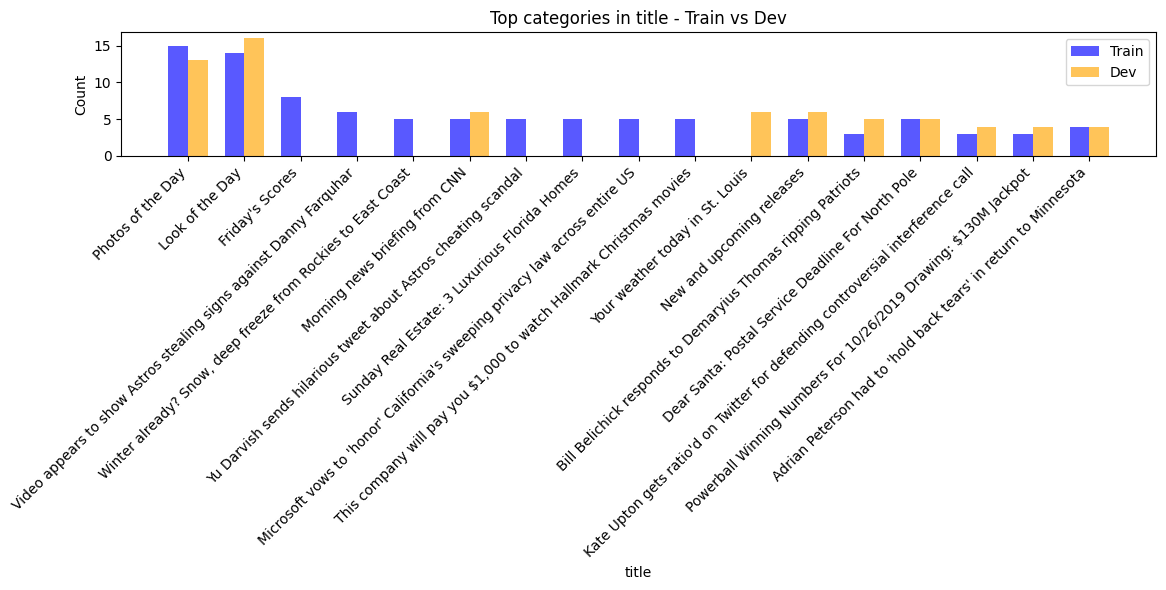


Unique Values and Distribution for abstract:
Train Dataset:
abstract
What's the weather today? What's the weather for the week? Here's your forecast.                                                                                                                                                                                                                                       124
Trailer 1                                                                                                                                                                                                                                                                                                               27
Our top photos from the last 24 hours.                                                                                                                                                                                                                                                                      

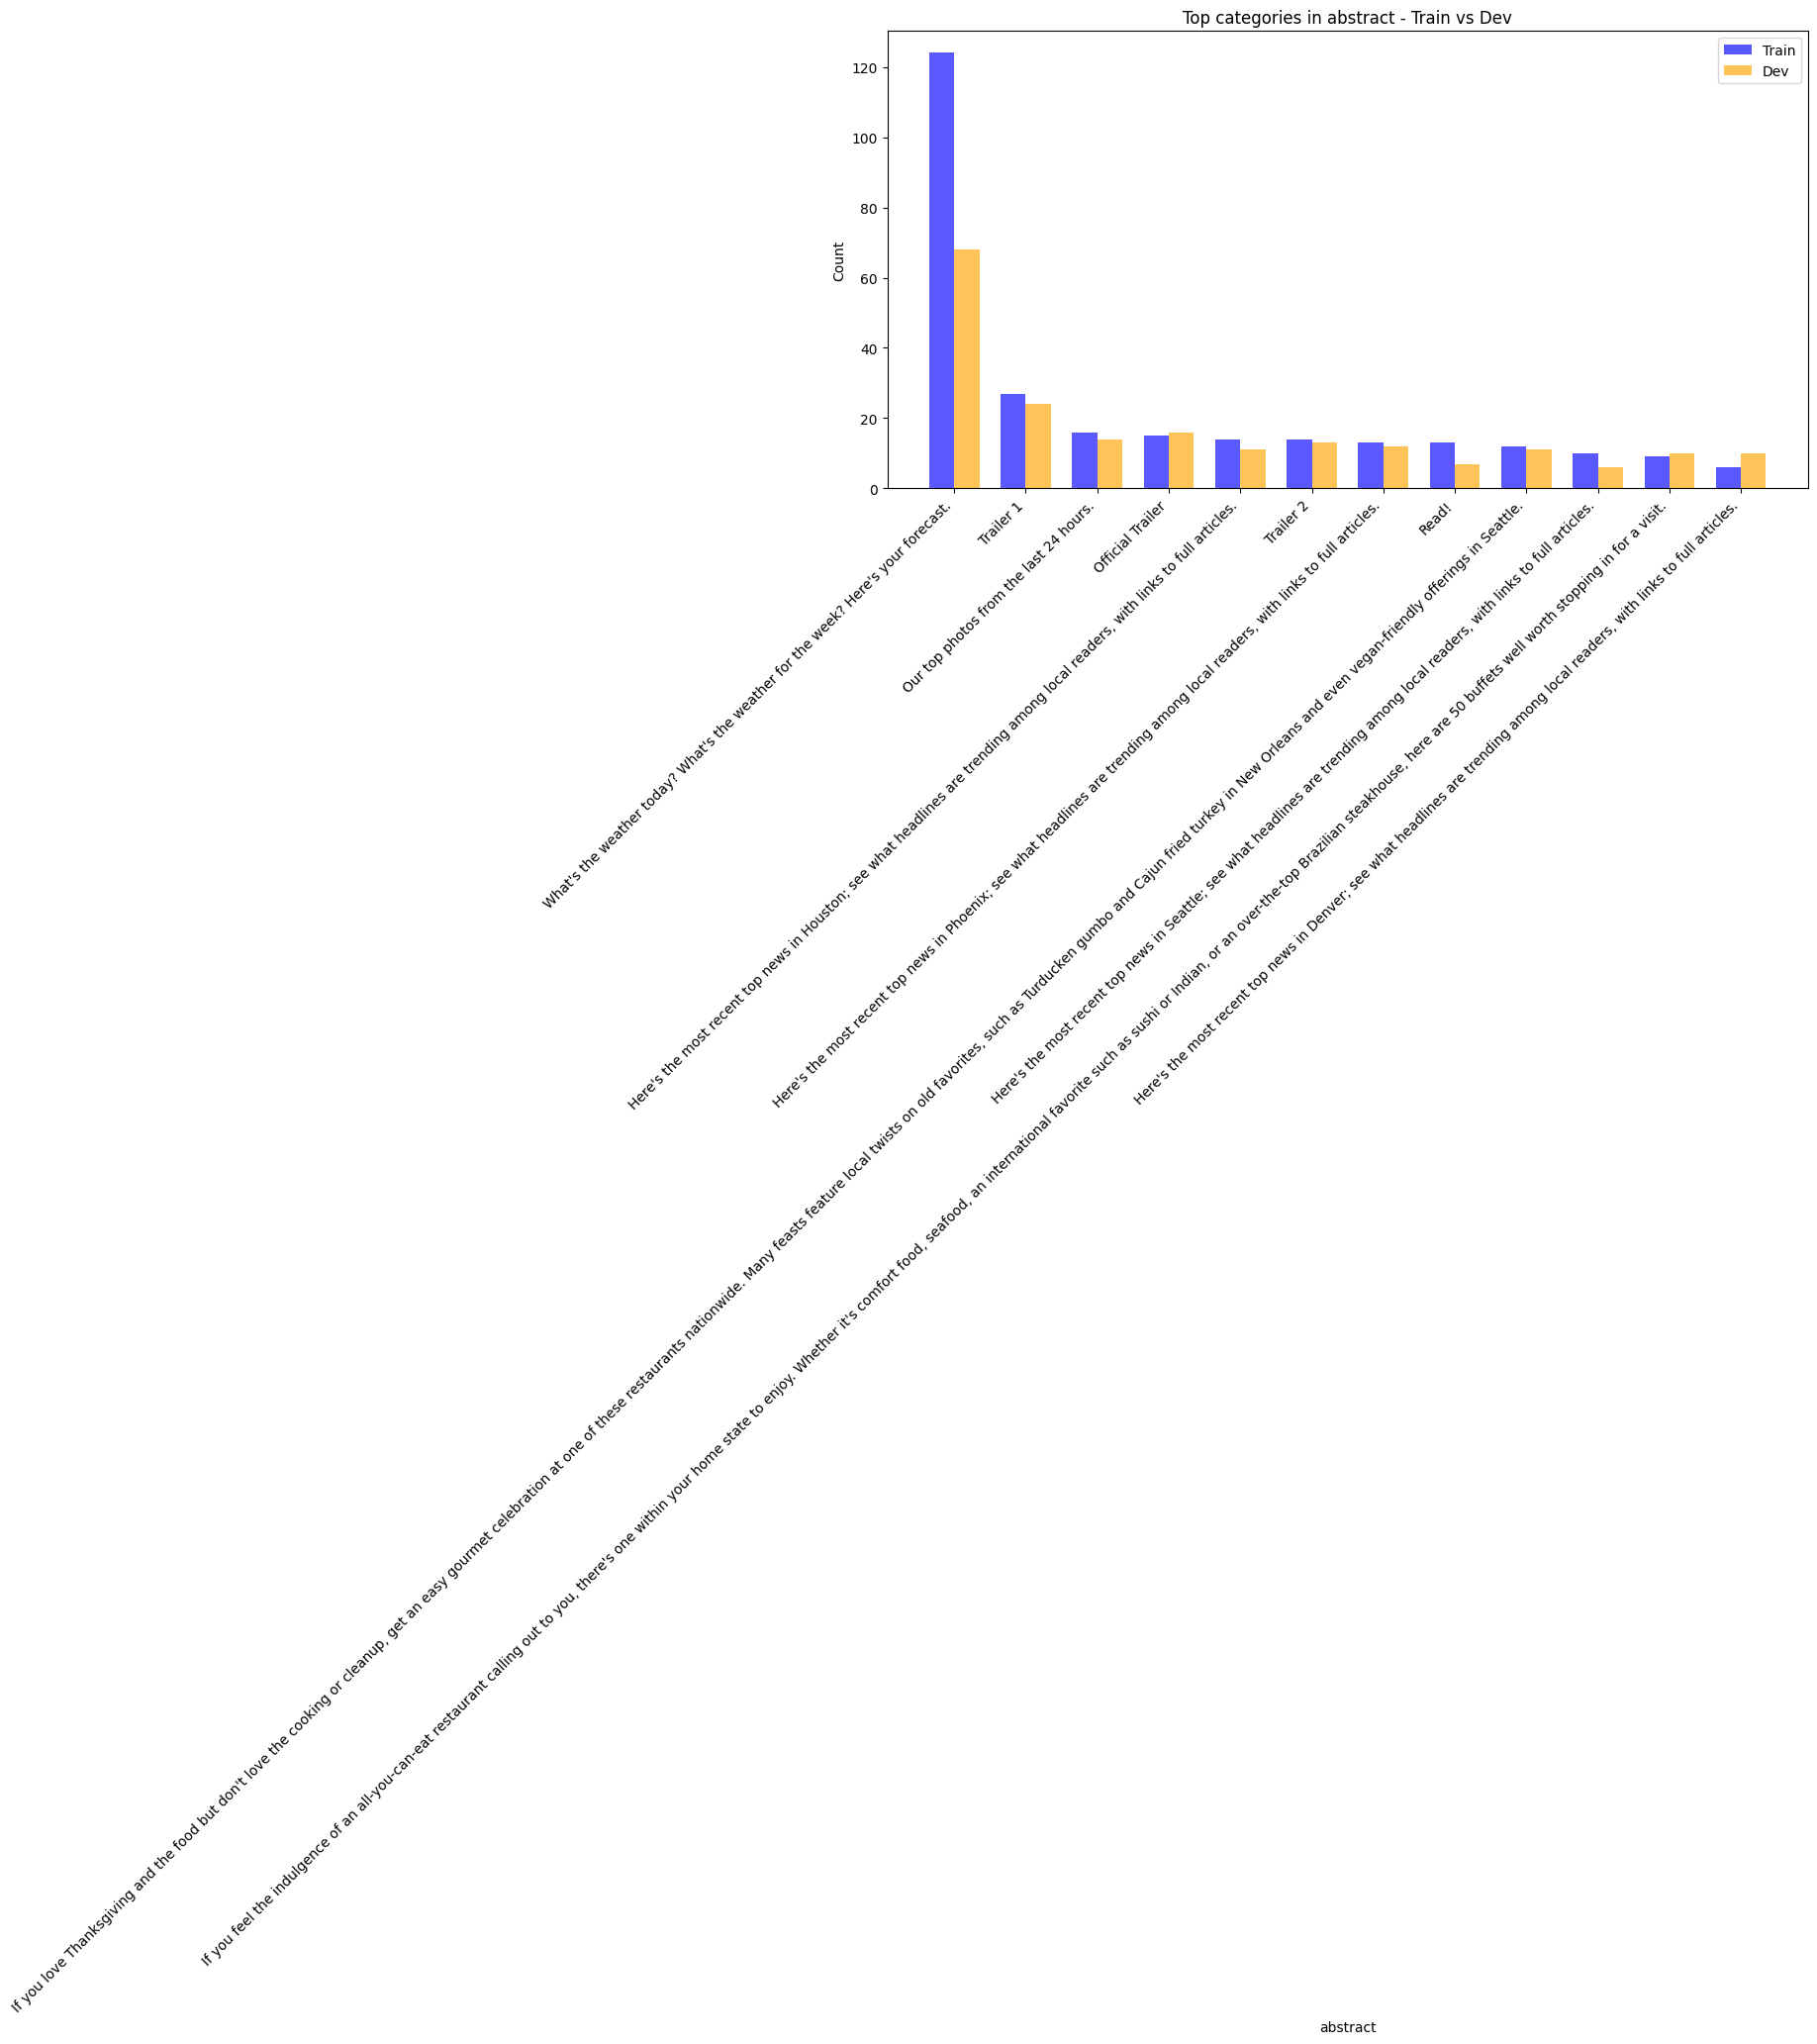


Additional Information:
              Metric  Train Value  Dev Value
      Total Articles        51282      42416
   Unique Categories           17         17
Unique Subcategories          264        257

 Dataset: Behaviors Dataset

Train Dataset Shape: (156965, 5)
Dev Dataset Shape: (73152, 5)

Data Types and Missing Values:
       Column Data Type_x  Train Non-Null Count  Train Null Count  Train Null Percentage Data Type_y  Dev Non-Null Count  Dev Null Count  Dev Null Percentage
 impressionId       int64                156965                 0                0.00000       int64               73152               0             0.000000
       userId      object                156965                 0                0.00000      object               73152               0             0.000000
    timestamp      object                156965                 0                0.00000      object               73152               0             0.000000
click_history      object             

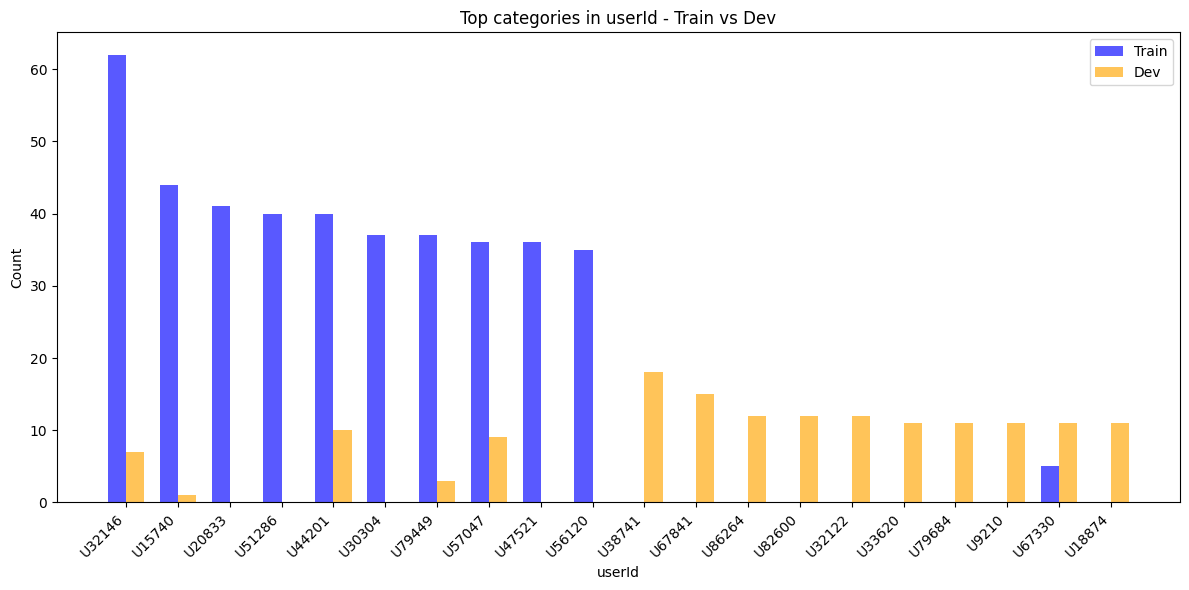


Unique Values and Distribution for timestamp:
Train Dataset:
timestamp
11/13/2019 11:11:34 AM    6
11/11/2019 12:00:37 PM    6
11/12/2019 7:12:22 AM     6
11/13/2019 9:52:05 AM     6
11/13/2019 10:55:30 AM    6
11/13/2019 9:23:28 AM     6
11/11/2019 11:47:52 AM    6
11/14/2019 11:01:17 AM    6
11/12/2019 8:21:15 AM     6
11/12/2019 2:02:15 PM     5
Number of unique values: 125501

Dev Dataset:
timestamp
11/15/2019 8:06:57 AM     10
11/15/2019 7:20:41 AM     10
11/15/2019 7:35:55 AM      9
11/15/2019 6:55:49 AM      9
11/15/2019 8:36:40 AM      9
11/15/2019 9:13:10 AM      8
11/15/2019 9:43:02 AM      8
11/15/2019 9:37:53 AM      8
11/15/2019 12:46:37 PM     8
11/15/2019 12:58:18 PM     8
Number of unique values: 40320


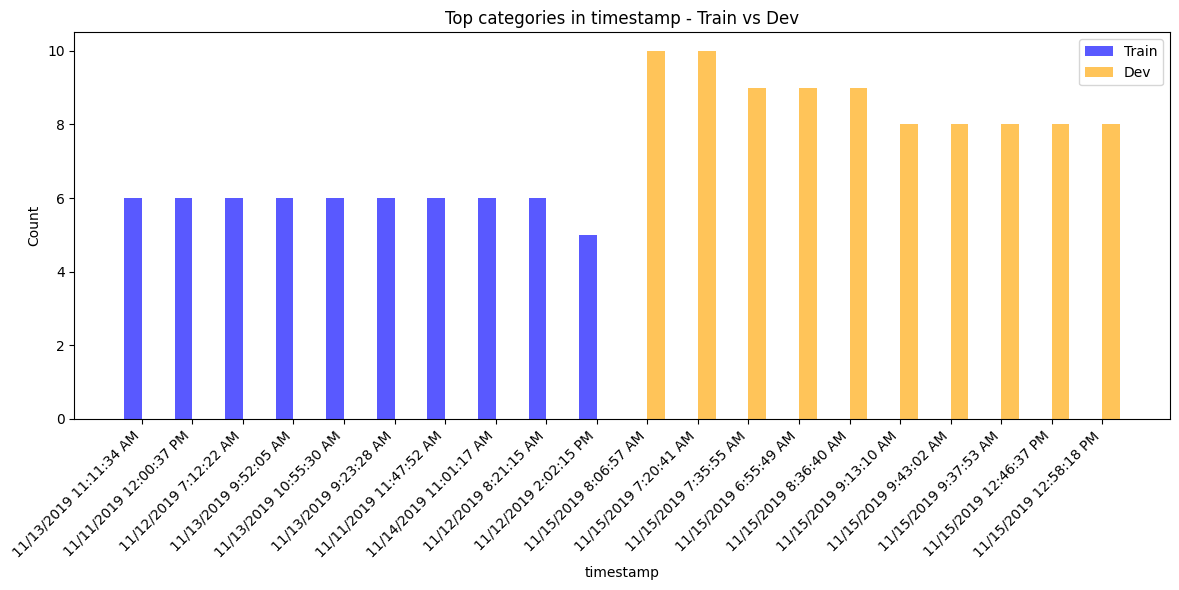


Unique Values and Distribution for impressions:
Train Dataset:
impressions
N35729-0 N55689-1    452
N55689-1 N35729-0    421
N55689-0 N53585-1    220
N287-1 N39010-0      205
N39010-0 N287-1      204
N53585-1 N55689-0    203
N55689-1 N6693-0     178
N49279-1 N61022-0    174
N63970-0 N58363-1    173
N6693-0 N55689-1     172
Number of unique values: 143617

Dev Dataset:
impressions
N36779-0 N20036-1    692
N20036-1 N36779-0    661
N24802-0 N29862-1    213
N20036-0 N36779-1    198
N29862-1 N24802-0    195
N36779-1 N20036-0    179
N512-0 N28640-1      100
N53572-0 N37352-1     98
N28640-1 N512-0       96
N29862-1 N53572-0     94
Number of unique values: 67949


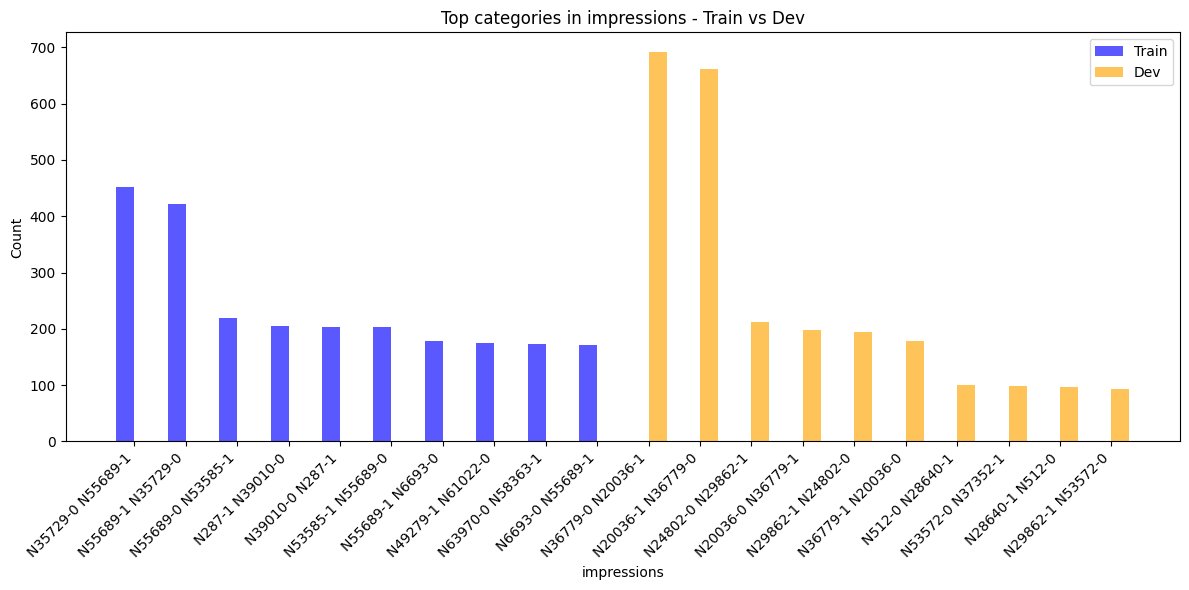


Additional Information:
           Metric                                Train Value                                  Dev Value
Total Impressions                                     156965                                      73152
     Unique Users                                      50000                                      50000
       Date Range 2019-11-09 00:00:19 to 2019-11-14 23:59:13 2019-11-15 00:00:01 to 2019-11-15 23:58:03


In [12]:
def inspect_data_comparative(train_df, dev_df, dataset_name):
    """
    Function to comprehensively inspect and compare train and dev datasets,
    including missing values, data types, statistics, and distribution of categorical variables.
    """
    print(f"\n{'='*60}")
    print(f" Dataset: {dataset_name}")
    print(f"{'='*60}\n")

    # Basic Info
    print(f"Train Dataset Shape: {train_df.shape}")
    print(f"Dev Dataset Shape: {dev_df.shape}")

    # Data Types and Missing Values
    def get_info_df(df, prefix):
        return pd.DataFrame({
            'Column': df.columns,
            'Data Type': df.dtypes,
            f'{prefix} Non-Null Count': df.notnull().sum(),
            f'{prefix} Null Count': df.isnull().sum(),
            f'{prefix} Null Percentage': (df.isnull().sum() / len(df)) * 100
        })

    train_info = get_info_df(train_df, 'Train')
    dev_info = get_info_df(dev_df, 'Dev')
    info_df = pd.merge(train_info, dev_info, on='Column')

    print("\nData Types and Missing Values:")
    print(info_df.to_string(index=False))

    # Basic Statistics
    print("\nBasic Statistics (Train):")
    print(train_df.describe(include='all').transpose().to_string())
    print("\nBasic Statistics (Dev):")
    print(dev_df.describe(include='all').transpose().to_string())

    # Categorical Variables Analysis
    excluded_columns = ['click_history', 'url', 'title_entities', 'abstract_entities', 'itemId']
    categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

    for col in categorical_cols:
        if col not in excluded_columns:
            print(f"\nUnique Values and Distribution for {col}:")

            train_counts = train_df[col].value_counts()
            dev_counts = dev_df[col].value_counts()

            print("Train Dataset:")
            print(train_counts.head(10).to_string())
            print(f"Number of unique values: {len(train_counts)}")

            print("\nDev Dataset:")
            print(dev_counts.head(10).to_string())
            print(f"Number of unique values: {len(dev_counts)}")

            # Plotting distribution
            plt.figure(figsize=(12, 6))

            # Get top 10 categories from both datasets
            top_categories = pd.concat([train_counts.head(10), dev_counts.head(10)]).index.unique()

            train_values = train_counts.reindex(top_categories).fillna(0)
            dev_values = dev_counts.reindex(top_categories).fillna(0)

            x = np.arange(len(top_categories))
            width = 0.35

            plt.bar(x - width/2, train_values, width, label='Train', color='blue', alpha=0.65)
            plt.bar(x + width/2, dev_values, width, label='Dev', color='orange', alpha=0.65)

            plt.title(f'Top categories in {col} - Train vs Dev')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks(x, top_categories, rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.show()

    # Additional dataset-specific information
    if 'news' in dataset_name.lower():
        additional_info = pd.DataFrame({
            'Metric': ['Total Articles', 'Unique Categories', 'Unique Subcategories'],
            'Train Value': [
                len(train_df),
                train_df['category'].nunique(),
                train_df['subcategory'].nunique()
            ],
            'Dev Value': [
                len(dev_df),
                dev_df['category'].nunique(),
                dev_df['subcategory'].nunique()
            ]
        })
    elif 'behaviors' in dataset_name.lower():
        train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], format='%m/%d/%Y %I:%M:%S %p')
        dev_df['timestamp'] = pd.to_datetime(dev_df['timestamp'], format='%m/%d/%Y %I:%M:%S %p')
        additional_info = pd.DataFrame({
            'Metric': ['Total Impressions', 'Unique Users', 'Date Range'],
            'Train Value': [
                len(train_df),
                train_df['userId'].nunique(),
                f"{train_df['timestamp'].min()} to {train_df['timestamp'].max()}"
            ],
            'Dev Value': [
                len(dev_df),
                dev_df['userId'].nunique(),
                f"{dev_df['timestamp'].min()} to {dev_df['timestamp'].max()}"
            ]
        })
    else:
        additional_info = pd.DataFrame()

    print("\nAdditional Information:")
    print(additional_info.to_string(index=False))

    return {
        'info_df': info_df,
        'additional_info': additional_info
    }

# Run inspections
news_result = inspect_data_comparative(train_news, dev_news, "News Dataset")
behaviors_result = inspect_data_comparative(train_behaviors, dev_behaviors, "Behaviors Dataset")


Distribution of category in News Dataset:

Top 10 categories:
                Train      Dev    Total
category                               
news          15774.0  13043.0  28817.0
sports        14510.0  11760.0  26270.0
finance        3107.0   2563.0   5670.0
foodanddrink   2551.0   2248.0   4799.0
lifestyle      2479.0   2132.0   4611.0
travel         2350.0   1845.0   4195.0
video          2068.0   1600.0   3668.0
health         1885.0   1715.0   3600.0
weather        2048.0   1462.0   3510.0
autos          1639.0   1490.0   3129.0

Unique values in Train: 17
Unique values in Dev: 17


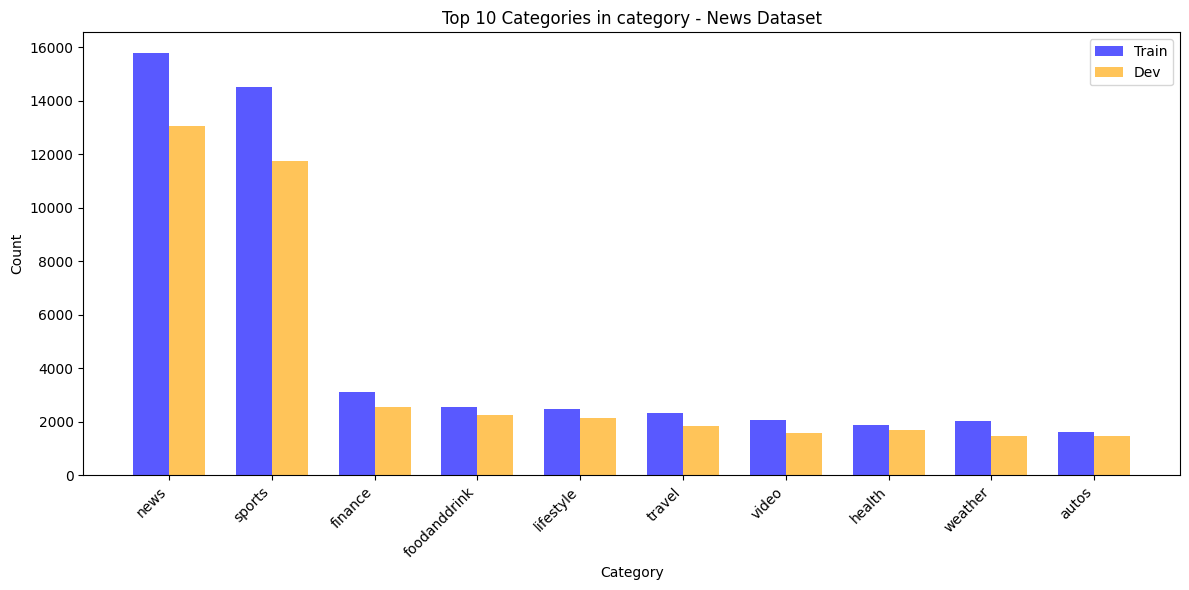


Distribution of subcategory in News Dataset:

Top 10 categories:
                           Train     Dev    Total
subcategory                                      
newsus                    6564.0  5335.0  11899.0
football_nfl              5420.0  4747.0  10167.0
newspolitics              2826.0  2398.0   5224.0
newscrime                 2254.0  1797.0   4051.0
weathertopstories         2047.0  1460.0   3507.0
newsworld                 1720.0  1525.0   3245.0
baseball_mlb              1661.0  1502.0   3163.0
football_ncaa             1665.0  1271.0   2936.0
basketball_nba            1555.0  1221.0   2776.0
newsscienceandtechnology  1210.0   971.0   2181.0

Unique values in Train: 264
Unique values in Dev: 257


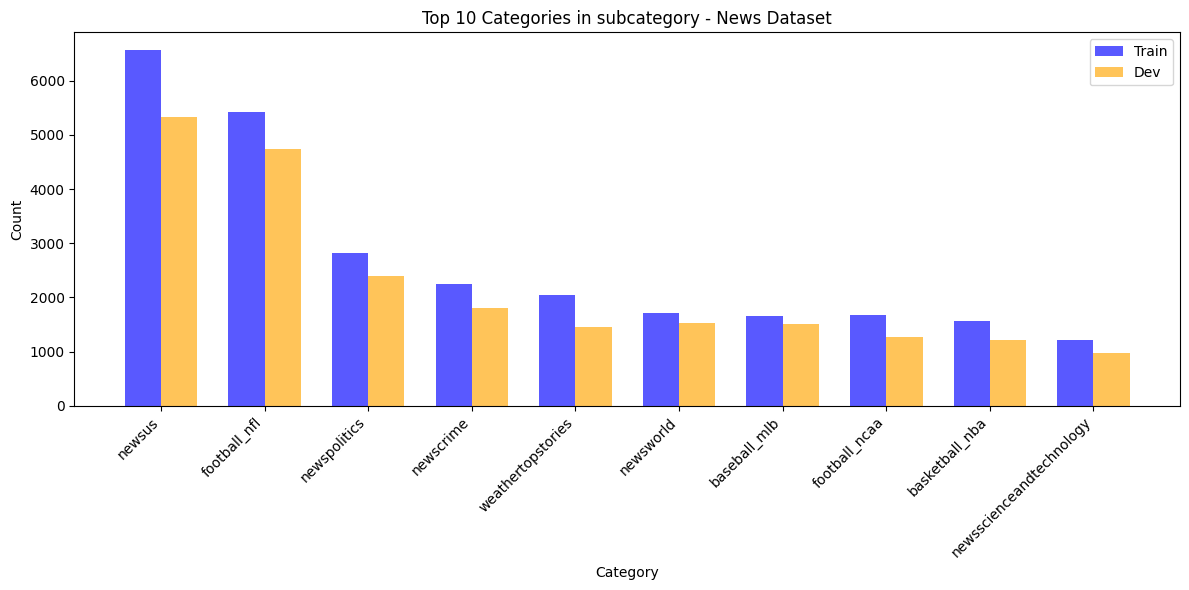


Distribution of userId in Behaviors Dataset:

Top 10 categories:
        Train   Dev  Total
userId                    
U32146   62.0   7.0   69.0
U44201   40.0  10.0   50.0
U57047   36.0   9.0   45.0
U15740   44.0   1.0   45.0
U20833   41.0   NaN   41.0
U51286   40.0   NaN   40.0
U79449   37.0   3.0   40.0
U79210   35.0   5.0   40.0
U85878   34.0   5.0   39.0
U30304   37.0   NaN   37.0

Unique values in Train: 50000
Unique values in Dev: 50000


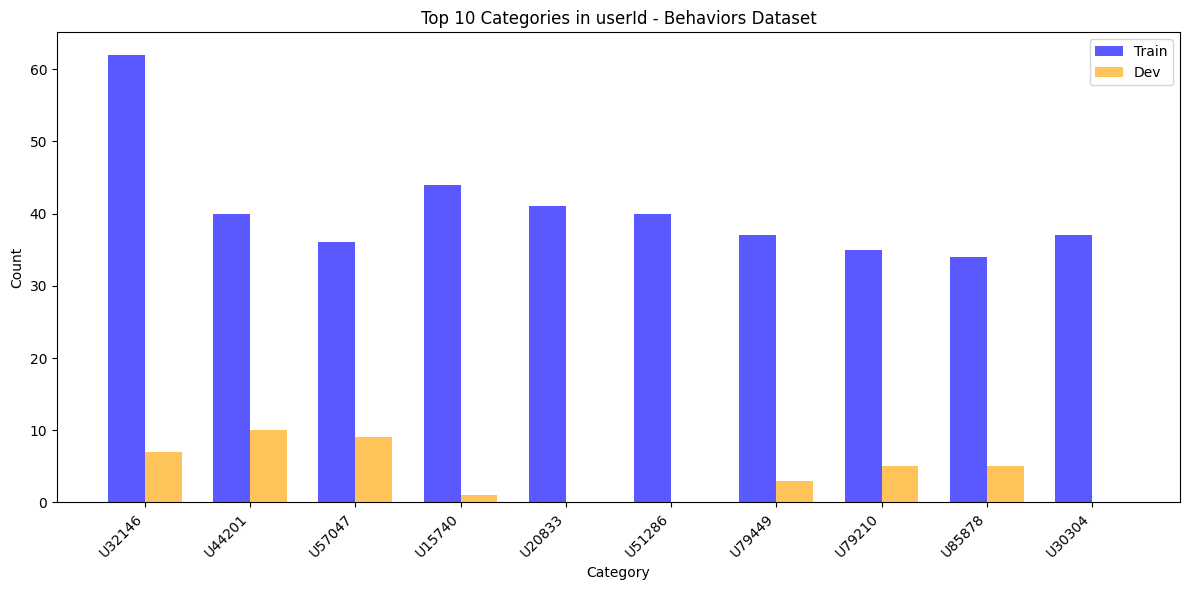

In [13]:
def analyze_categorical_distribution(train_df, dev_df, columns, dataset_name):
    """
    Function to analyze and compare the distribution of categorical variables
    between train and dev datasets.
    """
    for column in columns:
        if train_df[column].dtype == 'object' and dev_df[column].dtype == 'object':
            print(f"\n{'='*60}")
            print(f"Distribution of {column} in {dataset_name}:")
            print(f"{'='*60}")

            # Get value counts
            train_counts = train_df[column].value_counts()
            dev_counts = dev_df[column].value_counts()

            # Combine and sort by total count
            combined_counts = pd.concat([train_counts, dev_counts], axis=1, keys=['Train', 'Dev'])
            combined_counts['Total'] = combined_counts.sum(axis=1)
            combined_counts = combined_counts.sort_values('Total', ascending=False)

            # Display top 10 categories
            print("\nTop 10 categories:")
            print(combined_counts.head(10).to_string())

            # Display summary statistics
            print(f"\nUnique values in Train: {train_df[column].nunique()}")
            print(f"Unique values in Dev: {dev_df[column].nunique()}")

            # Plotting
            plt.figure(figsize=(12, 6))

            # Get top 10 categories
            top_categories = combined_counts.head(10).index

            # Prepare data for plotting
            train_data = train_counts.reindex(top_categories).fillna(0)
            dev_data = dev_counts.reindex(top_categories).fillna(0)

            # Create bar plot
            x = range(len(top_categories))
            width = 0.35

            plt.bar([i - width/2 for i in x], train_data, width, label='Train', color='blue', alpha=0.65)
            plt.bar([i + width/2 for i in x], dev_data, width, label='Dev', color='orange', alpha=0.65)

            plt.title(f'Top 10 Categories in {column} - {dataset_name}')
            plt.xlabel('Category')
            plt.ylabel('Count')
            plt.xticks(x, top_categories, rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.show()

        else:
            print(f"\n{column} is not a categorical column in both datasets.")

# Analyze unique values and categorical distribution for news datasets
analyze_categorical_distribution(train_news, dev_news, ['category', 'subcategory'], "News Dataset")

# Analyze unique values and categorical distribution for behaviors datasets
analyze_categorical_distribution(train_behaviors, dev_behaviors, ['userId'], "Behaviors Dataset")

### 2. Behavioral Analysis


User Interaction Analysis for Behaviors Dataset

Top 10 Most Clicked Articles:
          Train      Dev    Total
N306    20765.0   9733.0  30498.0
N42620  17918.0  10116.0  28034.0
N45794  15200.0   7678.0  22878.0
N31801  15694.0   6867.0  22561.0
N43142  14565.0   6971.0  21536.0
N871    14210.0   6852.0  21062.0
N47020  15216.0   4964.0  20180.0
N55189  13394.0   6669.0  20063.0
N29177  13243.0   6060.0  19303.0
N16715  13011.0   6122.0  19133.0

Total Unique Articles Clicked in Train: 33195
Total Unique Articles Clicked in Dev: 37681


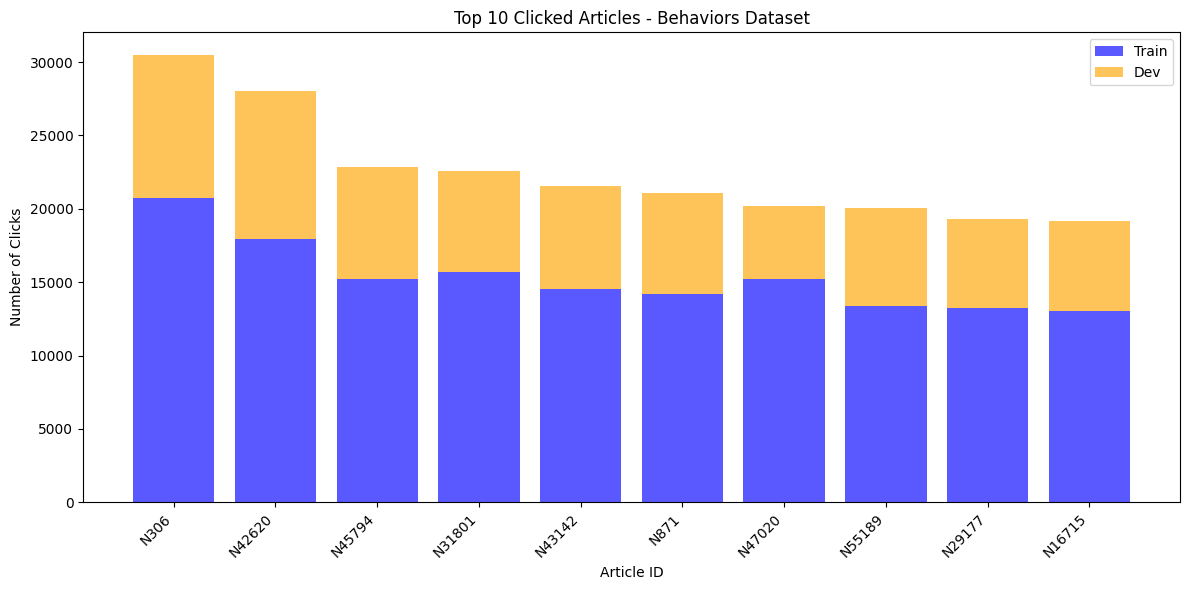


Users with no click history in Train: 3238 (2.06%)
Users with no click history in Dev: 2214 (3.03%)


In [14]:
def analyze_user_interactions(train_df, dev_df, dataset_name):
    """
    Analyze how often users click on certain articles in both train and dev datasets.
    Handles NaN values in click_history.
    """
    print(f"\n{'='*60}")
    print(f"User Interaction Analysis for {dataset_name}")
    print(f"{'='*60}")

    def process_clicks(df):
        # Filter out NaN values and convert to string
        click_histories = df['click_history'].dropna().astype(str)
        all_clicks = [item for sublist in click_histories.str.split() for item in sublist if item]
        click_counts = Counter(all_clicks)
        return pd.Series(click_counts).sort_values(ascending=False)

    train_clicks = process_clicks(train_df)
    dev_clicks = process_clicks(dev_df)

    print("\nTop 10 Most Clicked Articles:")
    combined_clicks = pd.DataFrame({'Train': train_clicks, 'Dev': dev_clicks}).fillna(0)
    combined_clicks['Total'] = combined_clicks['Train'] + combined_clicks['Dev']
    combined_clicks = combined_clicks.sort_values('Total', ascending=False)
    print(combined_clicks.head(10).to_string())

    print(f"\nTotal Unique Articles Clicked in Train: {len(train_clicks)}")
    print(f"Total Unique Articles Clicked in Dev: {len(dev_clicks)}")

    # Plotting
    plt.figure(figsize=(12, 6))
    top_articles = combined_clicks.head(10).index

    plt.bar(range(10), combined_clicks['Train'].head(10), label='Train', alpha=0.65, color='blue')
    plt.bar(range(10), combined_clicks['Dev'].head(10), bottom=combined_clicks['Train'].head(10),
            label='Dev', alpha=0.65, color='orange')

    plt.title(f'Top 10 Clicked Articles - {dataset_name}')
    plt.xlabel('Article ID')
    plt.ylabel('Number of Clicks')
    plt.xticks(range(10), top_articles, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Additional analysis: Users with no click history
    train_no_clicks = train_df['click_history'].isna().sum()
    dev_no_clicks = dev_df['click_history'].isna().sum()
    print(f"\nUsers with no click history in Train: {train_no_clicks} ({train_no_clicks/len(train_df)*100:.2f}%)")
    print(f"Users with no click history in Dev: {dev_no_clicks} ({dev_no_clicks/len(dev_df)*100:.2f}%)")

# Assuming train_behaviors and dev_behaviors are already loaded
analyze_user_interactions(train_behaviors, dev_behaviors, "Behaviors Dataset")

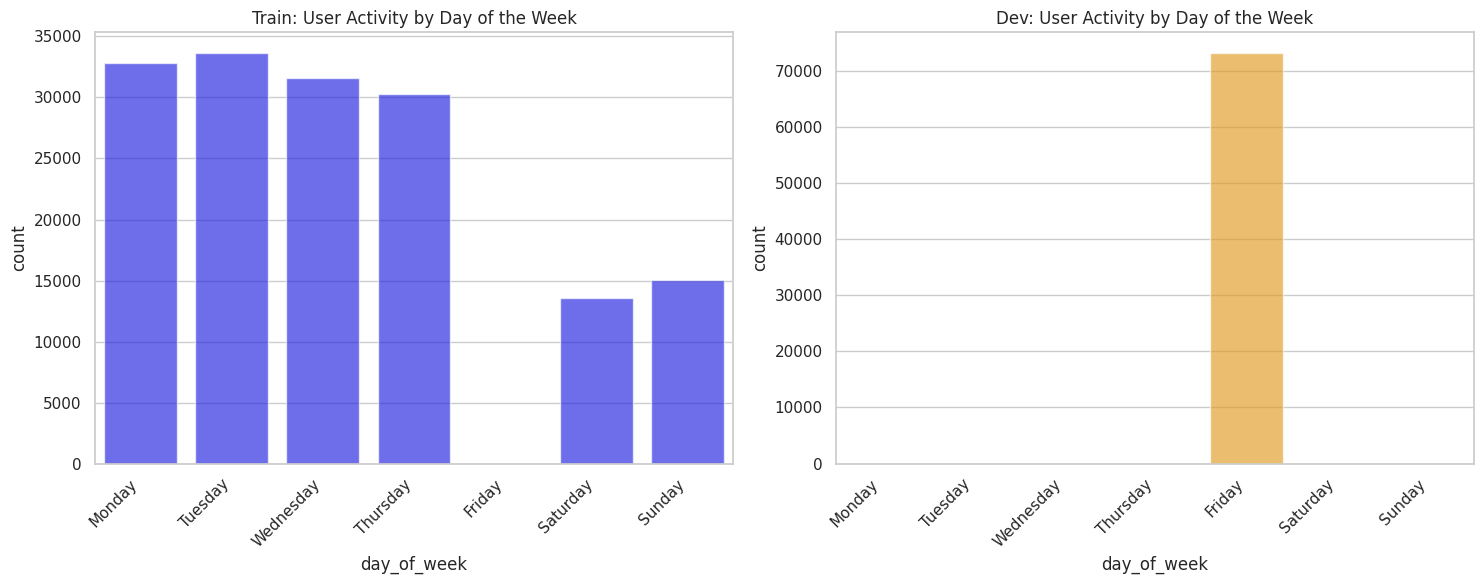

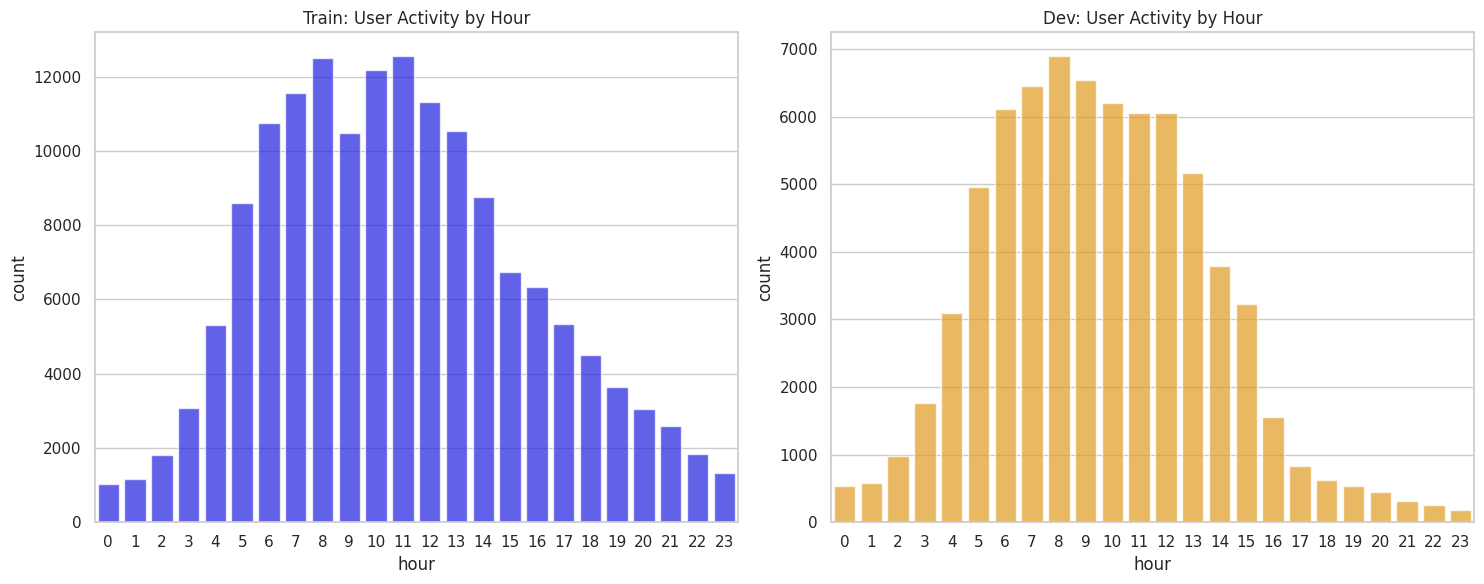

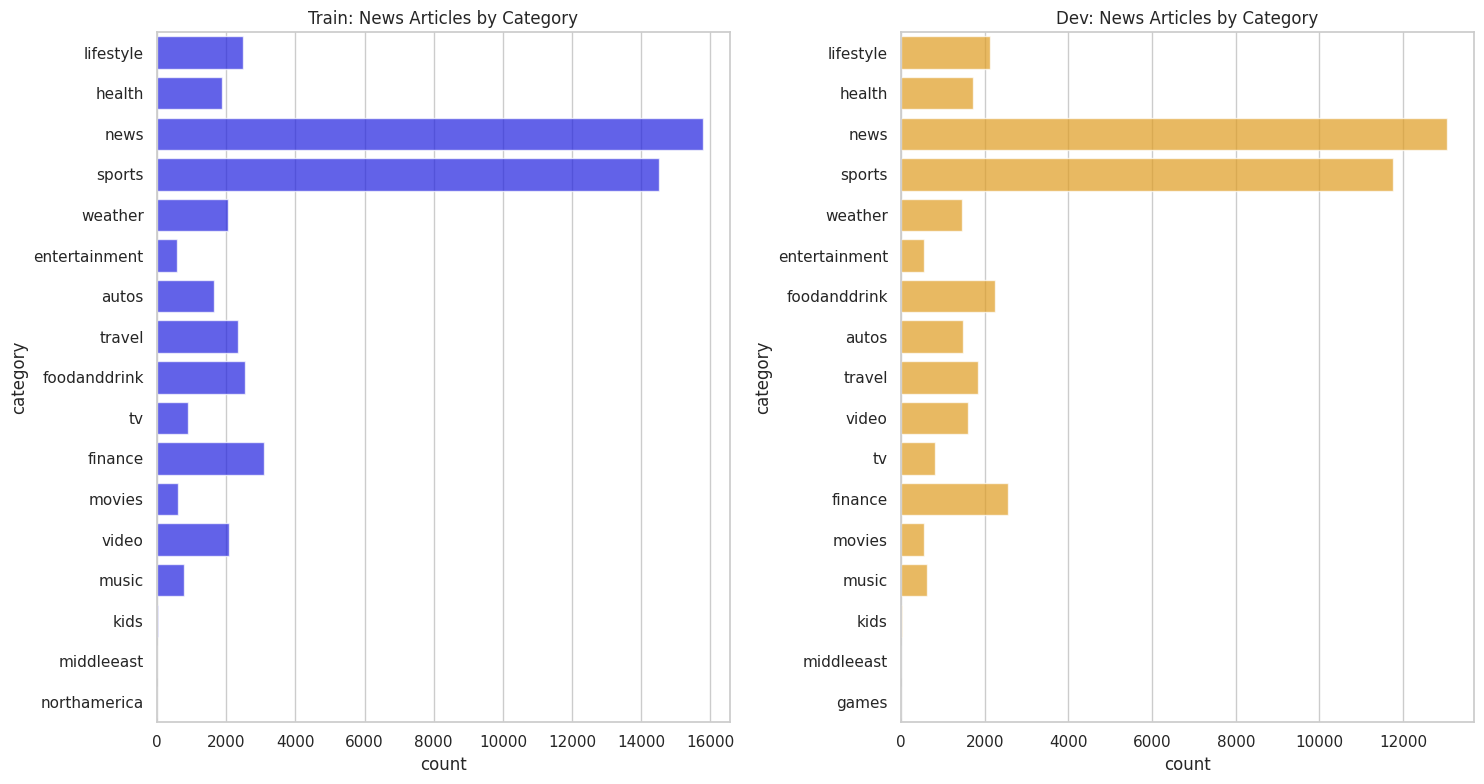

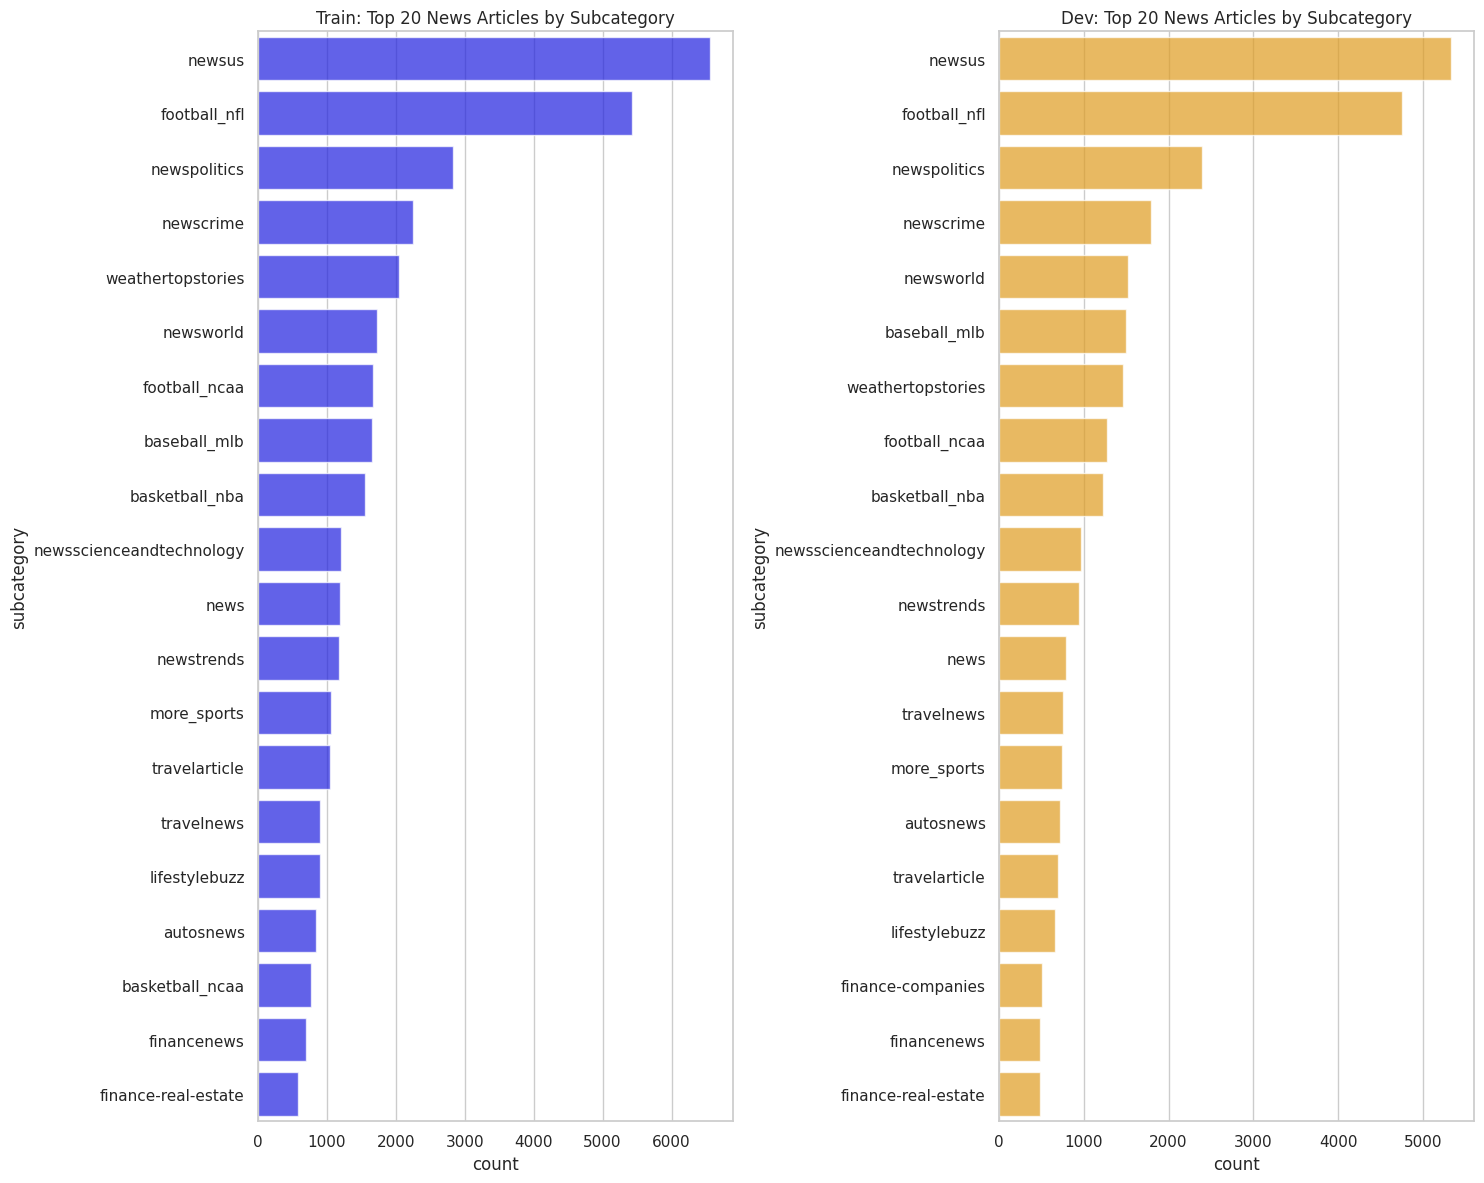

In [15]:
def visualize_comparative_distributions(train_behaviors, dev_behaviors, train_news, dev_news):
    """
    Create comparative visualizations for user activity and article categories
    between train (blue) and dev (orange) datasets.
    """
    # Prepare data
    for df in [train_behaviors, dev_behaviors]:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['day_of_week'] = df['timestamp'].dt.day_name()
        df['hour'] = df['timestamp'].dt.hour

    # Set up the plotting style
    sns.set(style="whitegrid")

    # 1. User Activity by Day of the Week
    plt.figure(figsize=(15, 6))
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    ax1 = plt.subplot(1, 2, 1)
    sns.countplot(data=train_behaviors, x='day_of_week', order=days_order, color='blue', ax=ax1, alpha=0.65)
    ax1.set_title('Train: User Activity by Day of the Week')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    ax2 = plt.subplot(1, 2, 2)
    sns.countplot(data=dev_behaviors, x='day_of_week', order=days_order, color='orange', ax=ax2, alpha=0.65)
    ax2.set_title('Dev: User Activity by Day of the Week')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    # 2. User Activity by Hour
    plt.figure(figsize=(15, 6))

    ax1 = plt.subplot(1, 2, 1)
    sns.countplot(data=train_behaviors, x='hour', color='blue', ax=ax1, alpha=0.7)
    ax1.set_title('Train: User Activity by Hour')

    ax2 = plt.subplot(1, 2, 2)
    sns.countplot(data=dev_behaviors, x='hour', color='orange', ax=ax2, alpha=0.7)
    ax2.set_title('Dev: User Activity by Hour')

    plt.tight_layout()
    plt.show()

    # 3. News Articles by Category
    plt.figure(figsize=(15, 8))

    ax1 = plt.subplot(1, 2, 1)
    sns.countplot(data=train_news, y='category', color='blue', ax=ax1, alpha=0.70)
    ax1.set_title('Train: News Articles by Category')

    ax2 = plt.subplot(1, 2, 2)
    sns.countplot(data=dev_news, y='category', color='orange', ax=ax2 , alpha=0.7)
    ax2.set_title('Dev: News Articles by Category')

    plt.tight_layout()
    plt.show()

    # 4. News Articles by Subcategory (Top 20 due to potentially large number of subcategories)
    def plot_top_subcategories(df, ax, title, color):
        top_subcats = df['subcategory'].value_counts().nlargest(20).index
        sns.countplot(data=df[df['subcategory'].isin(top_subcats)], y='subcategory', order=top_subcats, ax=ax, color=color, alpha=0.7)
        ax.set_title(title)

    plt.figure(figsize=(15, 12))

    ax1 = plt.subplot(1, 2, 1)
    plot_top_subcategories(train_news, ax1, 'Train: Top 20 News Articles by Subcategory', 'blue')

    ax2 = plt.subplot(1, 2, 2)
    plot_top_subcategories(dev_news, ax2, 'Dev: Top 20 News Articles by Subcategory', 'orange')

    plt.tight_layout()
    plt.show()

# run the function
visualize_comparative_distributions(train_behaviors, dev_behaviors, train_news, dev_news)

### 3. Content Analysis


Frequent Words Analysis for title in News Dataset

Top 20 Most Frequent Words:
             Train   Dev  Total
new           2336  1852   4188
trump         1610  1371   2981
man           1462  1264   2726
says          1403  1229   2632
police        1324  1131   2455
week          1359  1082   2441
state         1123   811   1934
best          1018   903   1921
game          1000   835   1835
home           906   759   1665
football       921   720   1641
first          906   712   1618
school         924   692   1616
report         828   743   1571
fire           846   697   1543
crash          811   707   1518
day            867     0    867
impeachment    854     0    854
win            838     0    838
county         806     0    806


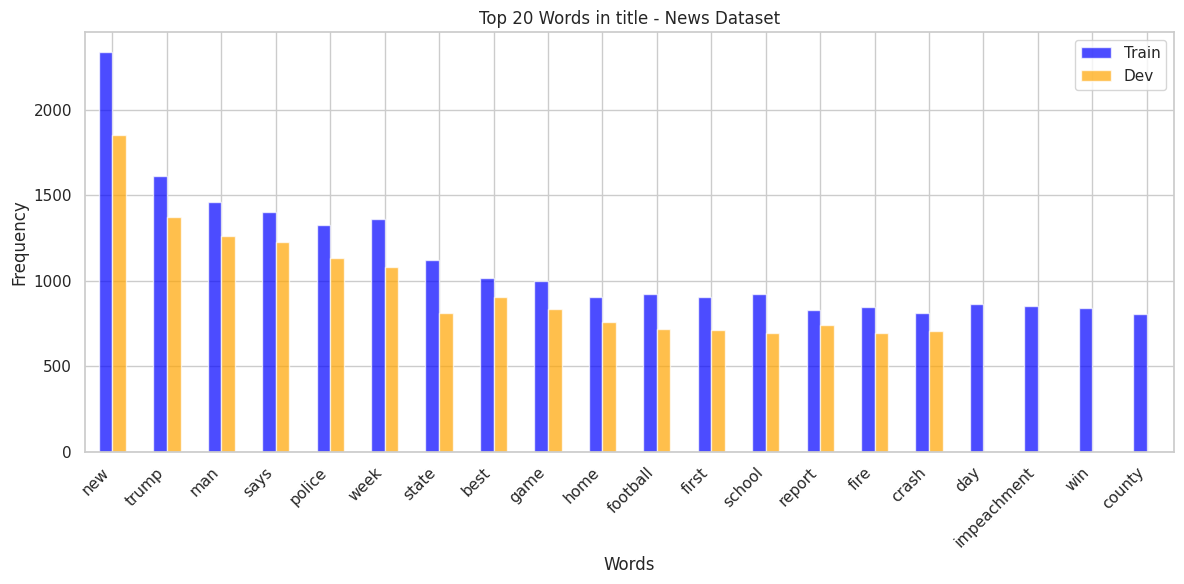

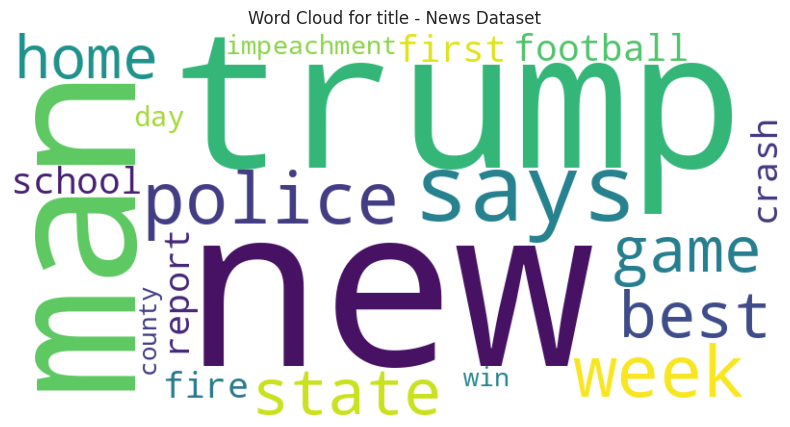


Frequent Words Analysis for abstract in News Dataset

Top 20 Most Frequent Words:
           Train   Dev  Total
said        6901  5576  12477
new         5422  4364   9786
one         4348  3481   7829
police      3967  3478   7445
first       3692  2763   6455
two         3435  2820   6255
week        3050  2413   5463
state       3043  2224   5267
president   2656  2161   4817
according   2609  2155   4764
county      2608  2103   4711
season      2620  1984   4604
game        2538  2036   4574
time        2530  2025   4555
home        2396  1961   4357
night       2426  1916   4342
last        2409  1908   4317
city        2378  1888   4266
tuesday     2340     0   2340
people      2262     0   2262


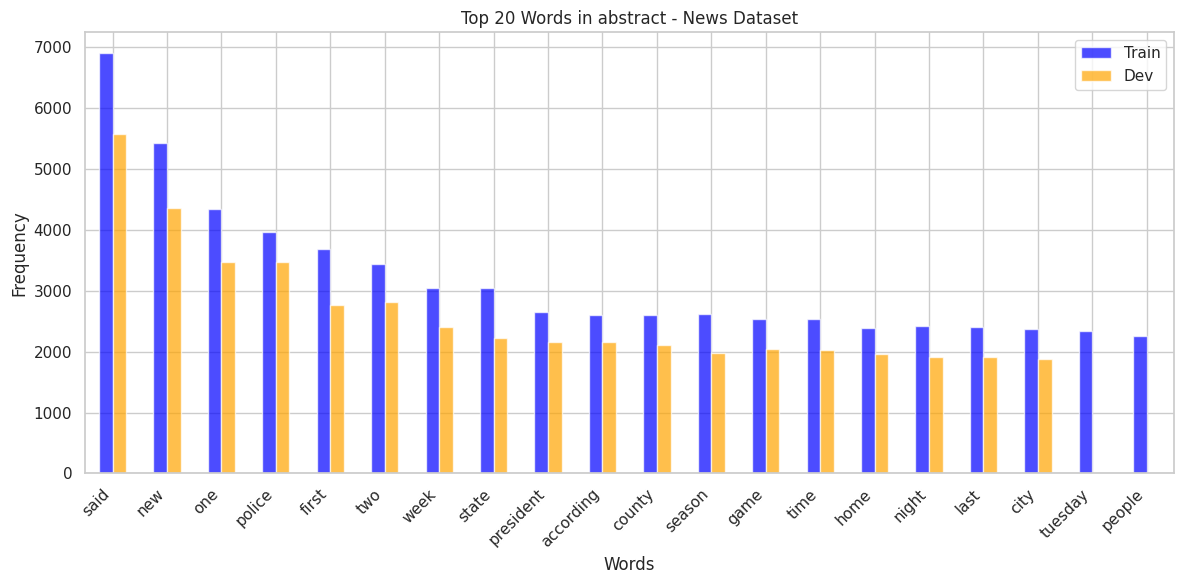

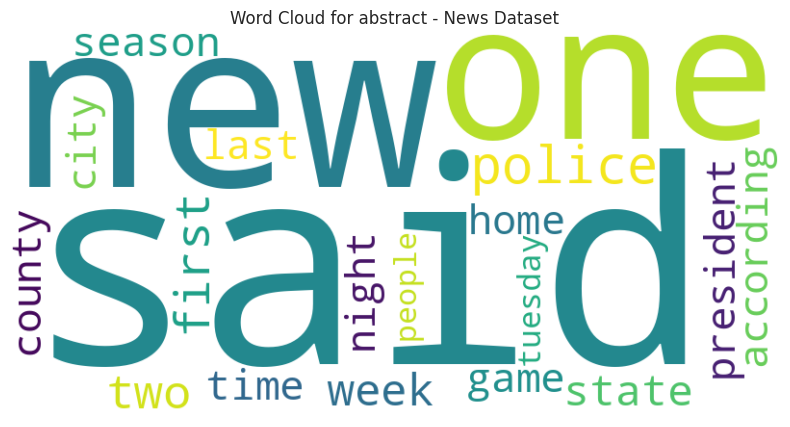


Keyword Extraction and Topic Categorization for title in News Dataset

Top Keywords (TF-IDF) in Train Dataset:
new: 857.4719
trump: 644.8203
says: 549.5414
week: 532.7160
man: 529.8875
best: 499.8342
police: 470.0506
state: 458.7861
game: 417.2801
home: 397.6519

Top Keywords (TF-IDF) in Dev Dataset:
new: 692.5198
trump: 547.5944
says: 481.3898
man: 451.6133
best: 444.0215
week: 423.4235
police: 393.5714
state: 343.5600
game: 335.8454
home: 334.3035

Predominant Topics in Train Dataset:
Other: 10

Predominant Topics in Dev Dataset:
Other: 10

Keyword Extraction and Topic Categorization for abstract in News Dataset

Top Keywords (TF-IDF) in Train Dataset:
new: 1038.5544
said: 954.8100
week: 657.0425
police: 640.9671
season: 604.2584
state: 600.2763
time: 589.2483
president: 563.7601
game: 546.6254
year: 533.2652

Top Keywords (TF-IDF) in Dev Dataset:
new: 869.5102
said: 779.9772
police: 549.9666
week: 532.8136
time: 488.4454
season: 484.3602
president: 459.8663
state: 451.2361
game: 44

In [16]:
def preprocess_text(text):
    """Clean and preprocess text data."""
    if pd.isna(text):
        return ""
    # Convert to lowercase and remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

def analyze_frequent_words(train_df, dev_df, column, dataset_name, top_n=20):
    """Analyze and compare most frequent words in train and dev datasets."""
    print(f"\n{'='*60}")
    print(f"Frequent Words Analysis for {column} in {dataset_name}")
    print(f"{'='*60}")

    def get_top_words(df, col):
        text = ' '.join(df[col].fillna('').apply(preprocess_text))
        words = nltk.word_tokenize(text)
        return Counter(words).most_common(top_n)

    train_top = dict(get_top_words(train_df, column))
    dev_top = dict(get_top_words(dev_df, column))

    all_words = list(set(train_top.keys()) | set(dev_top.keys()))
    combined = pd.DataFrame({
        'Train': [train_top.get(word, 0) for word in all_words],
        'Dev': [dev_top.get(word, 0) for word in all_words]
    }, index=all_words)
    combined['Total'] = combined['Train'] + combined['Dev']
    combined = combined.sort_values('Total', ascending=False).head(top_n)

    print(f"\nTop {top_n} Most Frequent Words:")
    print(combined.to_string())

    # Plotting
    plt.figure(figsize=(12, 6))
    combined[['Train', 'Dev']].plot(kind='bar', color=['blue', 'orange'], alpha=0.7, ax=plt.gca())
    plt.title(f'Top {top_n} Words in {column} - {dataset_name}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Word Cloud
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(combined['Total']))
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column} - {dataset_name}')
    plt.show()

def extract_keywords_and_topics(train_df, dev_df, column, dataset_name, n_keywords=10):
    """Extract keywords and categorize topics using TF-IDF."""
    print(f"\n{'='*60}")
    print(f"Keyword Extraction and Topic Categorization for {column} in {dataset_name}")
    print(f"{'='*60}")

    tfidf = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))

    def get_top_tfidf_words(df, col):
        tfidf_matrix = tfidf.fit_transform(df[col].fillna('').apply(preprocess_text))
        feature_names = tfidf.get_feature_names_out()
        tfidf_scores = tfidf_matrix.sum(axis=0).A1
        word_scores = list(zip(feature_names, tfidf_scores))
        return sorted(word_scores, key=lambda x: x[1], reverse=True)[:n_keywords]

    train_keywords = get_top_tfidf_words(train_df, column)
    dev_keywords = get_top_tfidf_words(dev_df, column)

    print("\nTop Keywords (TF-IDF) in Train Dataset:")
    for word, score in train_keywords:
        print(f"{word}: {score:.4f}")

    print("\nTop Keywords (TF-IDF) in Dev Dataset:")
    for word, score in dev_keywords:
        print(f"{word}: {score:.4f}")

    # Simple topic categorization based on top keywords
    def categorize_topics(keywords):
        topics = []
        for word, _ in keywords:
            if 'politic' in word or 'government' in word:
                topics.append('Politics')
            elif 'econom' in word or 'financ' in word or 'business' in word:
                topics.append('Economy')
            elif 'health' in word or 'medic' in word:
                topics.append('Health')
            elif 'tech' in word or 'scienc' in word:
                topics.append('Technology/Science')
            elif 'sport' in word:
                topics.append('Sports')
            else:
                topics.append('Other')
        return Counter(topics).most_common()

    train_topics = categorize_topics(train_keywords)
    dev_topics = categorize_topics(dev_keywords)

    print("\nPredominant Topics in Train Dataset:")
    for topic, count in train_topics:
        print(f"{topic}: {count}")

    print("\nPredominant Topics in Dev Dataset:")
    for topic, count in dev_topics:
        print(f"{topic}: {count}")

# Assuming train_news and dev_news are already loaded
analyze_frequent_words(train_news, dev_news, 'title', "News Dataset")
analyze_frequent_words(train_news, dev_news, 'abstract', "News Dataset")
extract_keywords_and_topics(train_news, dev_news, 'title', "News Dataset")
extract_keywords_and_topics(train_news, dev_news, 'abstract', "News Dataset")

# 4. Modeling

### 1. Preprocessing Data

In [24]:
def preprocess_data(news_df: pd.DataFrame) -> pd.DataFrame:
    """Preprocess news data by combining title and abstract."""
    news_df['title'] = news_df['title'].fillna('')
    news_df['abstract'] = news_df['abstract'].fillna('')
    news_df['content'] = news_df['title'] + " " + news_df['abstract']
    return news_df

train_news = preprocess_data(train_news)
dev_news = preprocess_data(dev_news)

# Display preprocessed news data
display(train_news.head())

,itemId,category,subcategory,title,abstract,url,title_entities,abstract_entities,content
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"The Brands Queen Elizabeth, Prince Charles, an..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...",50 Worst Habits For Belly Fat These seemingly ...
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",The Cost of Trump's Aid Freeze in the Trenches...
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",I Was An NBA Wife. Here's How It Affected My M...
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","How to Get Rid of Skin Tags, According to a De..."


### 2. TF-IDF Vectorization

In [25]:
def create_tfidf_vectors(train_content: List[str], dev_content: List[str]) -> Tuple[np.ndarray, np.ndarray]:
    """Create TF-IDF vectors for train and dev content."""
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    train_tfidf = vectorizer.fit_transform(train_content)
    dev_tfidf = vectorizer.transform(dev_content)
    return train_tfidf, dev_tfidf

train_tfidf, dev_tfidf = create_tfidf_vectors(train_news['content'], dev_news['content'])

# Display shape of TF-IDF vectors
print(f"Train TF-IDF shape: {train_tfidf.shape}")
print(f"Dev TF-IDF shape: {dev_tfidf.shape}")

Train TF-IDF shape: (51282, 5000)
Dev TF-IDF shape: (42416, 5000)


### 3. LLM Embeddings

In [19]:
def get_llm_embeddings(texts: List[str], model_name: str = 'sentence-transformers/all-MiniLM-L6-v2') -> np.ndarray:
    """Generate embeddings using a pre-trained language model."""
    model = SentenceTransformer(model_name)
    embeddings = model.encode(texts, show_progress_bar=True)
    return embeddings

dev_embeddings = get_llm_embeddings(dev_news['content'].tolist())

# Display the shape of LLM embeddings
print(f"Dev Embeddings shape: {dev_embeddings.shape}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1326 [00:00<?, ?it/s]

Dev Embeddings shape: (42416, 384)


### 4. Cosine Similarity Calculation

In [20]:
def calculate_cosine_similarity(embeddings: np.ndarray) -> np.ndarray:
    """Calculate cosine similarity matrix from embeddings."""
    return cosine_similarity(embeddings, embeddings)

cosine_sim_tfidf = calculate_cosine_similarity(dev_tfidf)
cosine_sim_llm = calculate_cosine_similarity(dev_embeddings)

# Display shapes of cosine similarity matrices
print(f"Cosine Similarity TF-IDF shape: {cosine_sim_tfidf.shape}")
print(f"Cosine Similarity LLM shape: {cosine_sim_llm.shape}")

Cosine Similarity TF-IDF shape: (42416, 42416)
Cosine Similarity LLM shape: (42416, 42416)


### 5. Get Similar Articles

In [26]:
def get_similar_articles(article_id: str, news_df: pd.DataFrame, cosine_sim: np.ndarray, num_recommendations: int = 5) -> pd.DataFrame:
    """Get similar articles based on cosine similarity."""
    idx = news_df[news_df['itemId'] == article_id].index[0]
    sim_scores = sorted(enumerate(cosine_sim[idx]), key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    return pd.DataFrame({
        'itemId': [news_df.iloc[i]['itemId'] for i, _ in sim_scores],
        'title': [news_df.iloc[i]['title'] for i, _ in sim_scores],
        'abstract': [news_df.iloc[i]['abstract'] for i, _ in sim_scores],
        'similarity_score': [score for _, score in sim_scores]
    })

# Example usage: Get similar articles for a specific article ID
article_id = dev_news['itemId'].iloc[0]
similar_articles = get_similar_articles(article_id, dev_news, cosine_sim_tfidf)
display(similar_articles)

,itemId,title,abstract,similarity_score
0,N9056,This Is What Queen Elizabeth Is Doing About th...,"According to royal insiders, Queen Elizabeth h...",0.605993
1,N38133,The cutest photos of royal children and their ...,See all the cute photos of royal children with...,0.527236
2,N60671,Prince Charles Teared Up When Prince William T...,"Frankly, it reduced me to tears, he said.",0.512445
3,N43522,Prince Charles is Getting Into Fashion,Prince Charles is now getting into fashion wit...,0.489382
4,N51725,Prince Charles Looks in Awe of Master Archie a...,"The photo, posted by the Duke and Duchess of S...",0.468659


### 6. Recommendation System Evaluation

In [23]:
def evaluate_recommendations(user_id: str, recommender_func, news_df: pd.DataFrame, behaviors_df: pd.DataFrame, cosine_sim: np.ndarray, k: int = 5) -> Dict[str, float]:
    """Evaluate recommendations for a user."""
    user_behavior = behaviors_df[behaviors_df['userId'] == user_id]
    if user_behavior.empty or pd.isna(user_behavior['click_history'].iloc[0]):
        logger.warning(f"User ID {user_id} has no valid click history.")
        return None

    click_history = user_behavior['click_history'].iloc[0].split()
    if not click_history:
        logger.warning(f"User ID {user_id} has an empty click history after splitting.")
        return None

    try:
        recommended_articles = recommender_func(click_history[-1], news_df, cosine_sim, num_recommendations=k)
        true_positives = len(set(click_history) & set(recommended_articles['itemId'].tolist()))
        precision = true_positives / k
        recall = true_positives / len(click_history)

        # Calculate NDCG
        relevance = [1 if item in click_history else 0 for item in recommended_articles['itemId']]
        ndcg = ndcg_score([relevance], [recommended_articles['similarity_score'].tolist()])

        # Calculate F1 score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'precision': precision,
            'recall': recall,
            'ndcg': ndcg,
            'f1': f1
        }
    except Exception as e:
        logger.error(f"Error occurred while getting recommendations for user {user_id}: {str(e)}")
        return None

# Example: Evaluate recommendations for a sample user
user_id = dev_behaviors['userId'].iloc[0]
metrics = evaluate_recommendations(user_id, get_similar_articles, dev_news, dev_behaviors, cosine_sim_tfidf)
print(metrics)

{'precision': 0.0, 'recall': 0.0, 'ndcg': 0.0, 'f1': 0}


### 7. Plot Metric Comparison

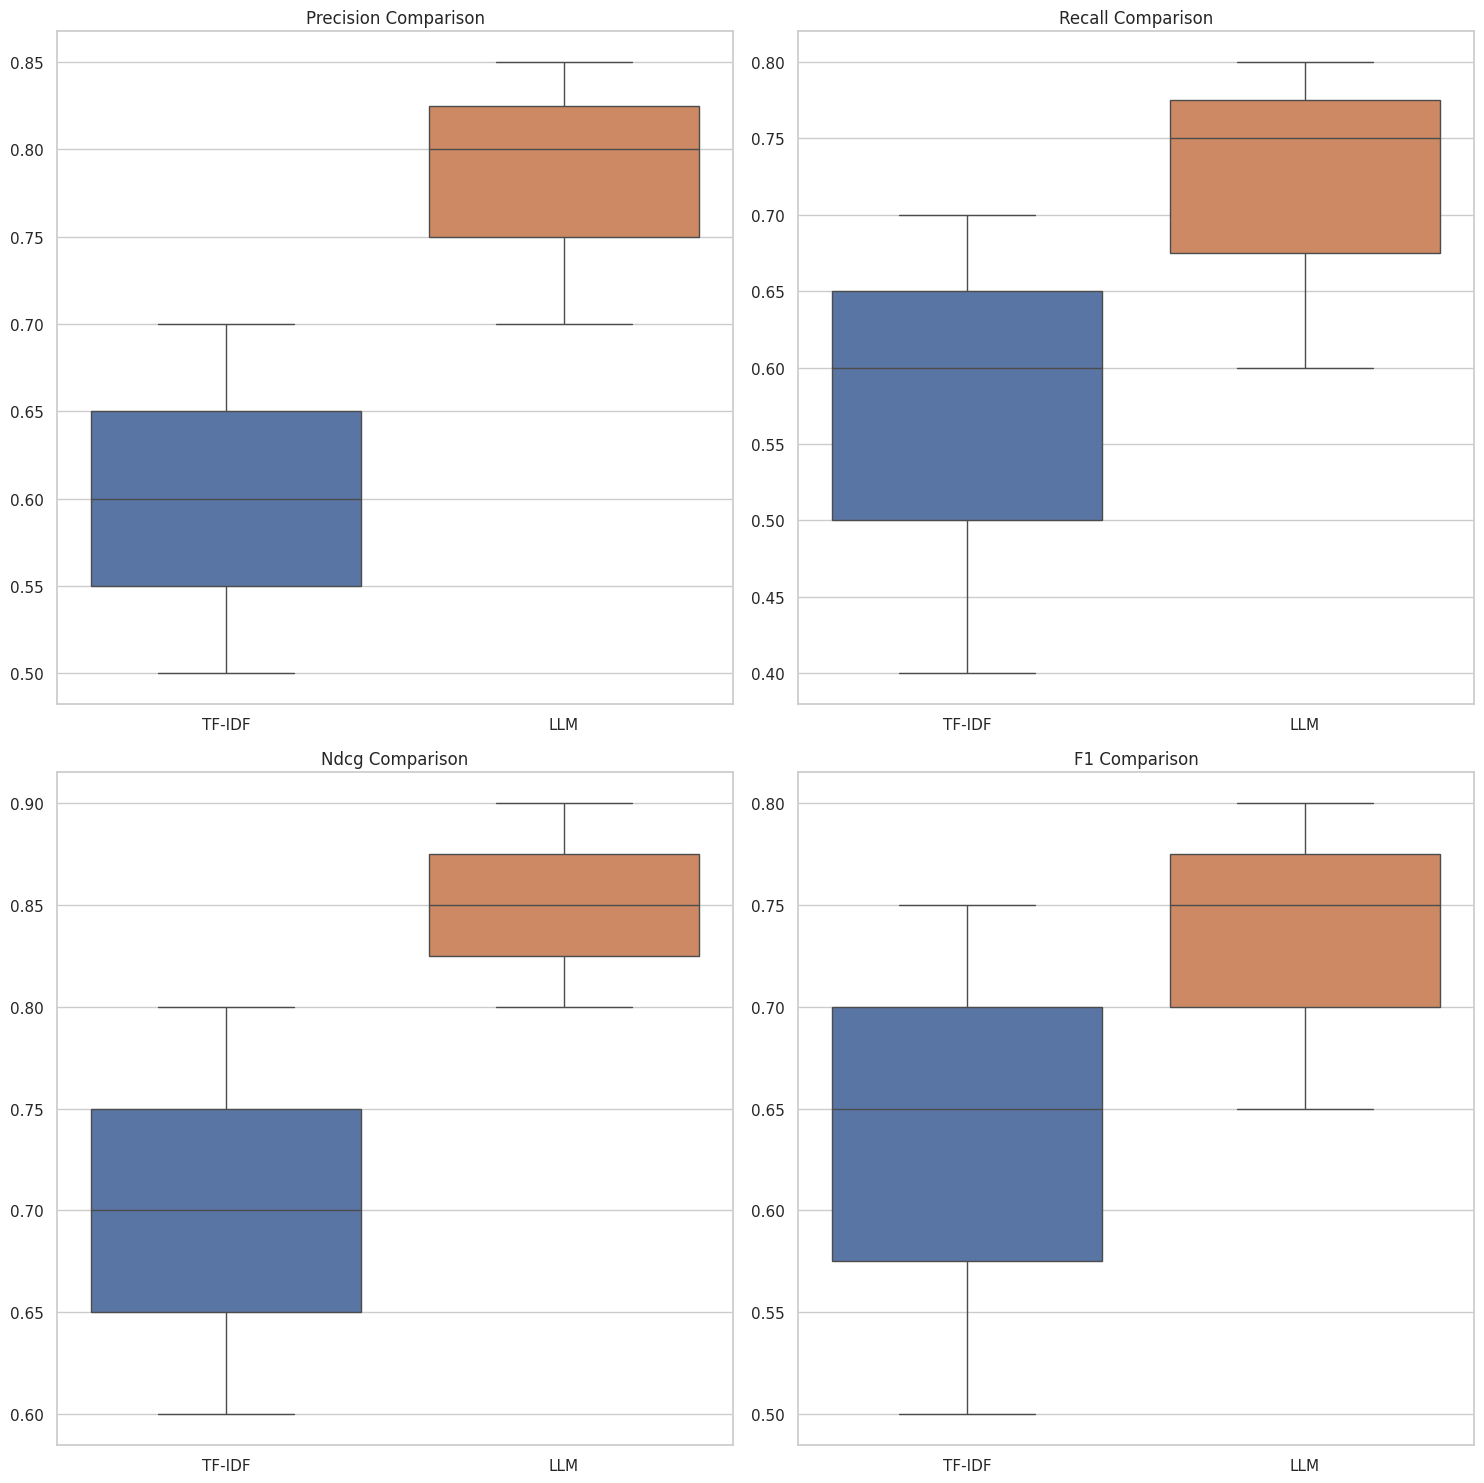

In [27]:
def plot_metric_comparison(tfidf_metrics: Dict[str, List[float]], llm_metrics: Dict[str, List[float]]):
    """Plot comparison of metrics between TF-IDF and LLM models."""
    metrics = ['precision', 'recall', 'ndcg', 'f1']
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    for i, metric in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        sns.boxplot(data=[tfidf_metrics[metric], llm_metrics[metric]], ax=ax)
        ax.set_title(f'{metric.capitalize()} Comparison')
        ax.set_xticklabels(['TF-IDF', 'LLM'])

    plt.tight_layout()
    display(plt.gcf())
    plt.close()

# Example: Plot comparison using sample data (provide appropriate metrics)
tfidf_metrics = {
    'precision': [0.5, 0.6, 0.7],
    'recall': [0.4, 0.6, 0.7],
    'ndcg': [0.6, 0.7, 0.8],
    'f1': [0.5, 0.65, 0.75]
}
llm_metrics = {
    'precision': [0.7, 0.8, 0.85],
    'recall': [0.6, 0.75, 0.8],
    'ndcg': [0.8, 0.85, 0.9],
    'f1': [0.65, 0.75, 0.8]
}

plot_metric_comparison(tfidf_metrics, llm_metrics)